# Fitting mean and log-normal scatter ##



In [8]:
import numpy as np
import pymc3 as pm
import math
from astropy.io import fits
import glob
import os
import matplotlib.pyplot as plt

Let's simulate a set of values with log-normal intrinsic scatter and statistical error

$$ \log S_{true} \sim Normal(\log\mu, \sigma_{int}) $$

$$ S_{obs} \sim Normal(S_{true}, \sigma_{stat})$$

In [9]:
#=== Set the directories
prof_dir = '/home/iacopo/projects/heritage_sx/profiles/tabs/'

#=== Look for the files
mean_peak  = glob.glob(prof_dir+"em_peak_prof_mean*.dat")

In [10]:
#nval = 100 # number of observed points
#mean = 1e-3 # true mean
#sigma_int = 0.2 # log-normal percentage scatter
#sigma_stat = 3e-4 #statistical error

#logvals_true = sigma_int * np.random.randn(nval) + np.log(mean)

#vals_obs = sigma_stat * np.random.randn(nval) + np.exp(logvals_true)

#IB: putting my data
#nval       = 100
#mean       = 100
#sigma_int  = 0.2
#sigma_stat = 1.5

#gov     = np.loadtxt('./dati_gov.dat')
#x_dat   = [x[0] for x in gov]
#y_dat   = [x[1] for x in gov]
#err_dat = [x[2] for x in gov]

### Read fits data and put 
#file_sx = '/home/iacopo/projects/heritage_sx/heritage_analysis/mean_peak_PSZ2G286.98+32.90.fits'
#hdulist = fits.open(file_sx)

##hdulist.info()

###print(hdulist[1].columns)

#scidata = hdulist[1].data

#radius = scidata.field('RADIUS')
#sx     = scidata.field('SB')
#err_sx = scidata.field('ERR_SB')

r_all        = []
prof_all     = []
prof_err_all = []

#=== Read the data from the dat file
for zz in range(0,len(mean_peak)):
    data_file = np.loadtxt(mean_peak[zz])
    r_r500    = [x[0] for x in data_file]
    em        = [x[1] for x in data_file]
    err_em    = [x[2] for x in data_file]
    r500      = [x[3] for x in data_file]
    dist_pc   = [x[4] for x in data_file]
    if (r500[0] <= 9.):
        for kk in range(0,len(r_r500)):
            r_all.append(r_r500[kk])
            prof_all.append(em[kk])
            prof_err_all.append(err_em[kk])
    


Plot the data

<Figure size 432x288 with 0 Axes>

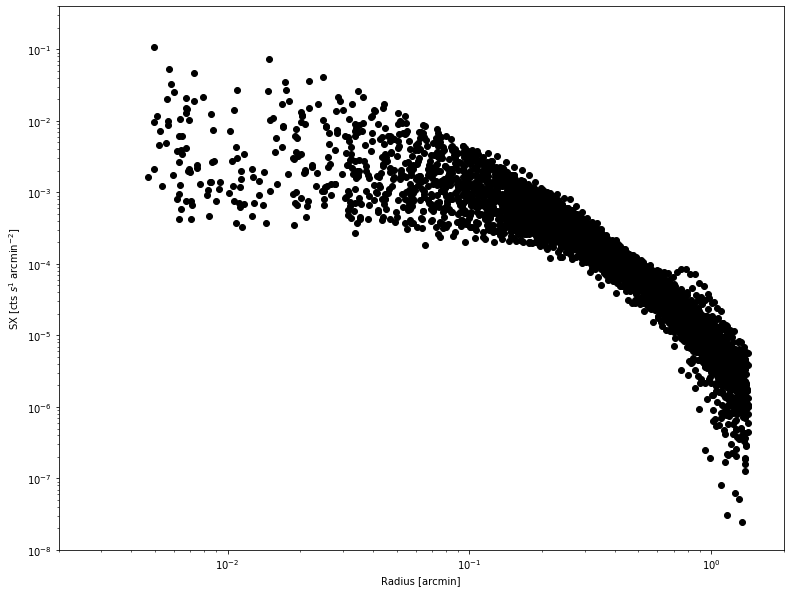

In [11]:
# Setting
plt.clf()
fig = plt.figure(figsize=(13,10))
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.002,2)
plt.ylim(1.e-8,0.4)
plt.xlabel('Radius [arcmin]')
plt.ylabel('SX [cts $s^{1}$ arcmin$^{-2}$]')

#Do the actual plot
plt.scatter(r_all,prof_all,color='black')
#plt.errorbar(radius,sx,yerr=err_sx,color='black',linestyle='none')


In [12]:
#=== Set the binning 
min_bin = min(r_all)
max_bin = max(r_all)
bin_rad = np.logspace(math.log10(min_bin), math.log10(max_bin), 30, endpoint=True)

#=== Making lists into array 
r_all        = np.array(r_all)
prof_all     = np.array(prof_all)
prof_err_all = np.array(prof_err_all)
        
#=== Initialise the matrix which contains the point for each bin
govj,govk       = 500,len(bin_rad)
matrix_r        = np.array([[-1. for x in range(govk)] for y in range(govj)])
matrix_prof     = np.array([[-1. for x in range(govk)] for y in range(govj)])
matrix_prof_err = np.array([[-1. for x in range(govk)] for y in range(govj)])

#=== Selecting the points in each bin    
for zz in range(0,len(bin_rad)-1):
    toto_r        = r_all[(r_all >= bin_rad[zz]) & (r_all <= bin_rad[zz+1])]
    toto_prof     = prof_all[(r_all >= bin_rad[zz]) & (r_all <= bin_rad[zz+1])]
    toto_prof_err = prof_err_all[(r_all >= bin_rad[zz]) & (r_all <= bin_rad[zz+1])]
    
    matrix_r[0:len(toto_r),zz]        = toto_r
    matrix_prof[0:len(toto_r),zz]     = toto_prof
    matrix_prof_err[0:len(toto_r),zz] = toto_prof_err


<ErrorbarContainer object of 3 artists>

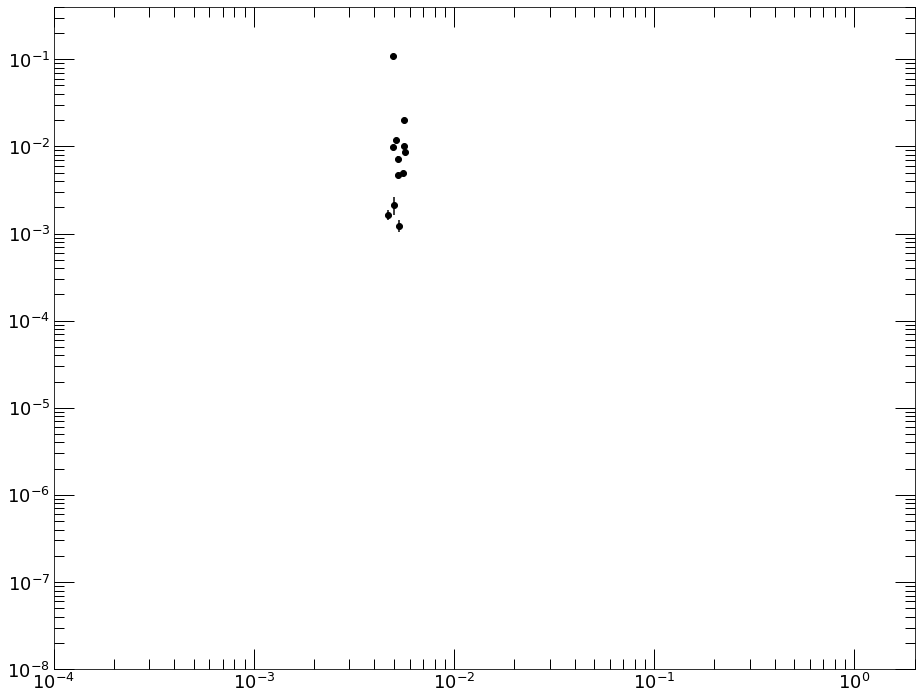

In [13]:

fig = plt.figure(figsize=(13,10))
ax = fig.add_axes([0.14, 0.14, 0.92, 0.92])
ax.tick_params(length=20, width=1, which='major',direction='in',right='on',top='on')
ax.tick_params(length=10, width=1, which='minor',direction='in',right='on',top='on')
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

#plt.plot(np.ones(nval)*mean, color='black', label='True')
#plt.plot(np.exp(logvals_true), 'o', label='Intrinsic')
#plt.plot(vals_obs, '*', label='Observed')
#plt.legend(fontsize=22)

#IB
zz = 0
plt.plot(matrix_r[:,zz],matrix_prof[:,zz],'o',color='black')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1.e-8,0.4)
plt.xlim(1.e-4,2)
plt.errorbar(matrix_r[:,zz],matrix_prof[:,zz],matrix_prof_err[:,zz],marker='.',linestyle='',color='k')


## PyMC3 model ##

We code this problem in PyMC3 in the following way: 

1. Our model has two parameters : the log-mean and the log-normal scatter on the log-mean. We start by setting up broad priors on these parameters:

$$    \ln\mu \sim Normal(mean=1e-3, sigma=10) $$\
$$    \sigma_{int} \sim HalfCauchy(beta=1.0)  $$

The Half-Cauchy prior allows us to implement the fact that the scatter is positive definite and its probably is low for very large values


2. To fit the data the values need to be transferred into linear scale rather than log. We do this by taking the exponential of $\ln\mu$. Since $\sigma(\log X) = \sigma(X)/X$ the scatter in linear scale is 

$$ \sigma_{lin} = \sigma_{int} * \mu $$ 


3. The total scatter $\sigma_{tot}$ is the quadratic sum of $\sigma_{lin}$ and $\sigma_{stat}$,

$$ \sigma_{tot} = \sqrt{\sigma_{lin}^2 + \sigma_{stat}^2} $$


4. We finish by setting up the likelihood, i.e. the observed data are a Normal realization of the mean and total scatter,

$$ Obs \sim Normal(\mu, \sigma_{tot})$$


In [7]:
#IB taking my data and get them ready for Dominique mambo jumbo
zz = 0

r_dat = matrix_r[:,zz]
r_dat = r_dat[(r_dat >-1)]

y_dat = matrix_prof[:,zz]
y_dat = y_dat[(y_dat >-1)]

err_dat = matrix_prof_err[:,zz]
err_dat = err_dat[(err_dat >-1)]

mean_ib = np.mean(y_dat,dtype=np.float64)
std_ib  = np.std(y_dat,dtype=np.float64)

print(mean_ib,std_ib)

#Using Dominique's model
model = pm.Model()

with model:
    
    mu = pm.Normal('mu', mu=np.log(mean_ib), sd=20)# Broad normal prior on log(mu)
    
    sd = pm.HalfCauchy('sd', beta=1) # Half-Cauchy prior on the scatter, strictly positive
    
    pred = pm.math.exp(mu) # The predicted value is exp(mu)
    
    sexp = sd * pred # The total scatter is the log-normal scatter times the predicted value
    
    err_dat_sq = [err_dat[0]**2. + sexp**2.]
    for zz in range(1,len(y_dat)):
        err_dat_sq.append(err_dat[zz]**2. + sexp**2)
        
    #totscat = pm.math.sqrt(0.001**2 + sexp**2) # The total scatter is the quadratic sum of intrinsic and statistical scatter
    totscat = pm.math.sqrt(err_dat_sq) # The total scatter is the quadratic sum of intrinsic and statistical scatter

    
    obs = pm.Normal('obs', mu=pred, sd=totscat, observed=y_dat) # Likelihood and fit to data
        
    trace = pm.sample(10000, tune=10000) # Run Hamiltonian Monte Carlo
      
all_means = np.exp(trace.get_values('mu'))
all_scat  = trace.get_values('sd')

mean_de, mean_err_de         = np.mean(all_means), np.std(all_means)
scat_de, scat_err_de         = np.mean(all_scat), np.std(all_scat)

print(mean_de,mean_err_de)
print(scat_de,scat_err_de)


0.014705662615384614 0.027689373643823876


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
Sampling 4 chains, 1,011 divergences: 100%|██████████| 80000/80000 [00:26<00:00, 2967.86draws/s]
The acceptance probability does not match the target. It is 0.9557264781434668, but should be close to 0.8. Try to increase the number of tuning steps.
There were 937 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.17451819000473795, but should be close to 0.8. Try to increase the number of tuning steps.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47933120387912087, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


0.014157808845171363 0.00723011988950217
6.534835697208313 129.42440374639122


<Figure size 432x288 with 0 Axes>

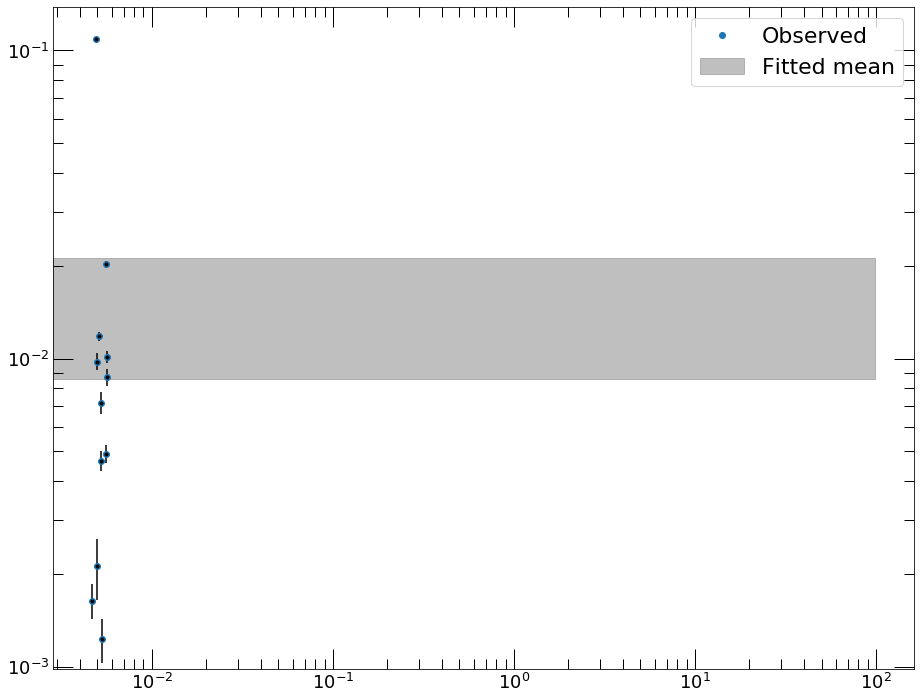

In [8]:
plt.clf()
fig = plt.figure(figsize=(13,10))
ax = fig.add_axes([0.14, 0.14, 0.92, 0.92])
ax.tick_params(length=20, width=1, which='major',direction='in',right='on',top='on')
ax.tick_params(length=10, width=1, which='minor',direction='in',right='on',top='on')
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

#IB 
nval = len(y_dat)
plt.yscale('log')
plt.xscale('log')

#plt.plot(np.ones(nval)*mean, color='black', label='True')
#plt.plot(np.exp(logvals_true), 'o', label='Intrinsic')
#plt.plot(np.exp(y_dat), 'o', label='Intrinsic')

#plt.plot(vals_obs, '*', label='Observed')
plt.plot(r_dat,y_dat, 'o', label='Observed')
plt.errorbar(r_dat,y_dat,err_dat,marker='.',linestyle='',color='k')


plt.fill_between(np.arange(0., 100., 1), np.percentile(all_means, 16.), 
                 np.percentile(all_means, 84.), color='grey', alpha=0.5, label='Fitted mean')

plt.legend(fontsize=22)

From here starts Dominique stuff. 

In [166]:
model = pm.Model()

#with model:
    
#    mu = pm.Normal('mu', mu=np.log(mean), sd=10) # Broad normal prior on log(mu)
    
#    sd = pm.HalfCauchy('sd', beta=1) # Half-Cauchy prior on the scatter, strictly positive
    
#    pred = pm.math.exp(mu) # The predicted value is exp(mu)
    
#    sexp = sd * pred # The total scatter is the log-normal scatter times the predicted value
    
#    totscat = pm.math.sqrt(sigma_stat**2 + sexp**2) # The total scatter is the quadratic sum of intrinsic and statistical scatter
            
#    obs = pm.Normal('obs', mu=pred, sd=totscat, observed=vals_obs) # Likelihood and fit to data
        
#    trace = pm.sample(10000, tune=10000) # Run Hamiltonian Monte Carlo
      
#IB get first rough estimate o mean and dispersion

    
with model:
    
    mu = pm.Normal('mu', mu=np.log(mean_ib), sd=std_ib) # Broad normal prior on log(mu)
    
    sd = pm.HalfCauchy('sd', beta=1) # Half-Cauchy prior on the scatter, strictly positive
    
    pred = pm.math.exp(mu) # The predicted value is exp(mu)
    
    sexp = sd * pred # The total scatter is the log-normal scatter times the predicted value
    
    err_dat_sq = [err_dat[0]**2. + sexp**2.]
    for zz in range(1,len(y_dat)):
        err_dat_sq.append(err_dat[zz]**2. + sexp**2)
        
    #totscat = pm.math.sqrt(5.**2 + sexp**2) # The total scatter is the quadratic sum of intrinsic and statistical scatter
    totscat = pm.math.sqrt(err_dat_sq) # The total scatter is the quadratic sum of intrinsic and statistical scatter

    
    obs = pm.Normal('obs', mu=pred, sd=totscat, observed=y_dat) # Likelihood and fit to data
        
    trace = pm.sample(2000, tune=2000) # Run Hamiltonian Monte Carlo
      
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:02<00:00, 5664.16draws/s]


## Results ##

/home/iacopo/Software/anaconda37/lib/python3.7/site-packages/arviz-0.6.1-py3.7.egg/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/iacopo/Software/anaconda37/lib/python3.7/site-packages/arviz-0.6.1-py3.7.egg/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82aa0eb950>,
      dtype=object)

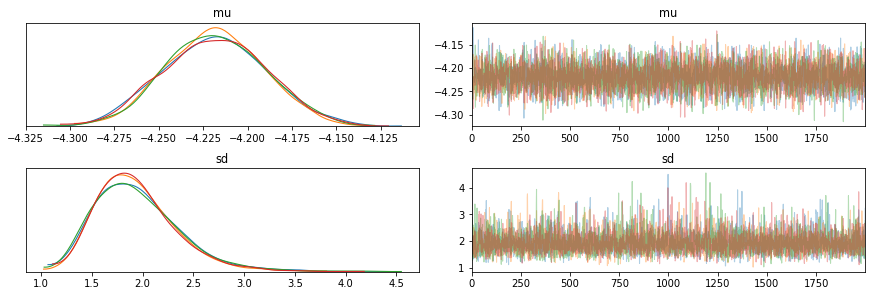

In [144]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f82a9e6cb90>,
      dtype=object)

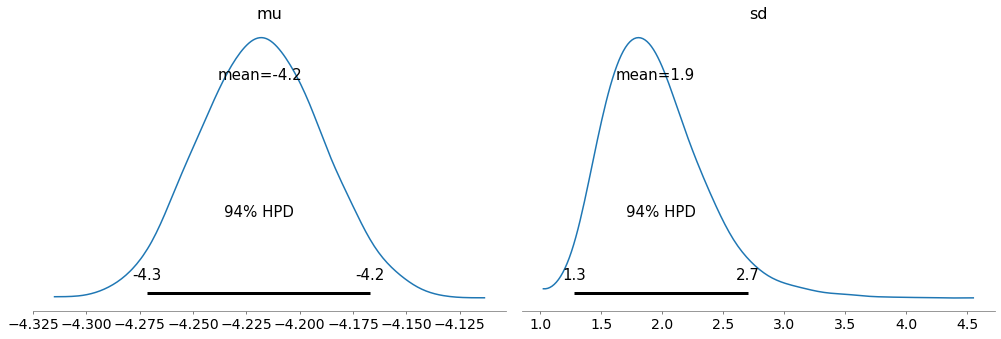

In [145]:
pm.plot_posterior(trace)

In [146]:
# Collecting output samples

all_means = np.exp(trace.get_values('mu'))

all_scat = trace.get_values('sd')

In [147]:
print('Fitted mean value and 1-sigma error: %g +/- %g' % (np.mean(all_means), np.std(all_means)))

Fitted mean value and 1-sigma error: 0.0147263 +/- 0.000413802


In [148]:
print('Fitted intrinsic scatter and 1-sigma error: %g +/- %g' % (np.mean(all_scat), np.std(all_scat)))

Fitted intrinsic scatter and 1-sigma error: 1.94262 +/- 0.407673


<Figure size 432x288 with 0 Axes>

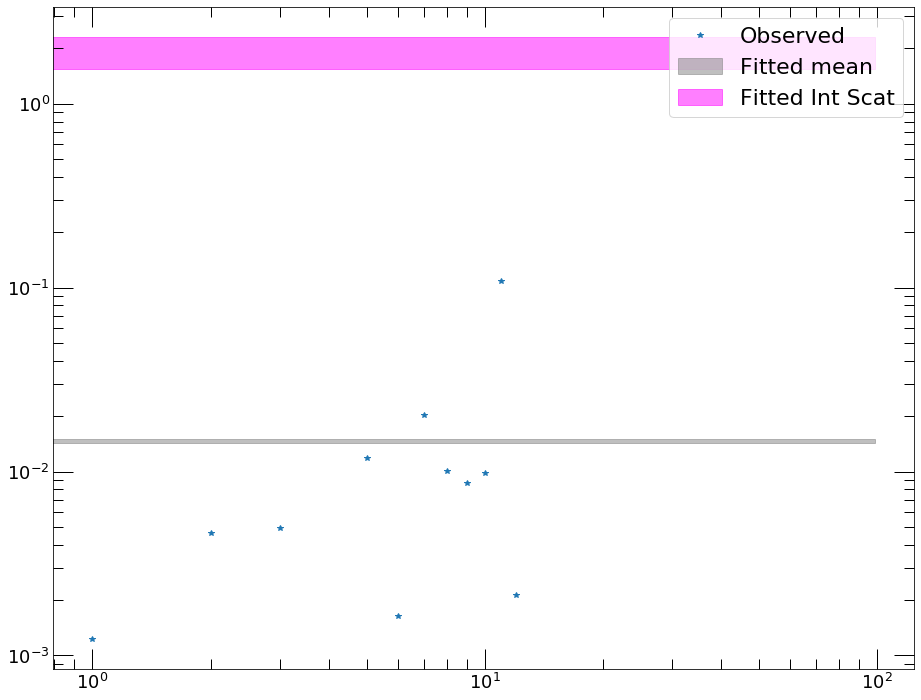

In [162]:
plt.clf()
fig = plt.figure(figsize=(13,10))
ax = fig.add_axes([0.14, 0.14, 0.92, 0.92])
ax.tick_params(length=20, width=1, which='major',direction='in',right='on',top='on')
ax.tick_params(length=10, width=1, which='minor',direction='in',right='on',top='on')
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

#IB 
nval = len(y_dat)
plt.yscale('log')
plt.xscale('log')

#plt.plot(np.ones(nval)*mean, color='black', label='True')
#plt.plot(np.exp(logvals_true), 'o', label='Intrinsic')
#plt.plot(np.exp(y_dat), 'o', label='Intrinsic')

#plt.plot(vals_obs, '*', label='Observed')
plt.plot(y_dat, '*', label='Observed')


plt.fill_between(np.arange(0., 100., 1), np.percentile(all_means, 16.), 
                 np.percentile(all_means, 84.), color='grey', alpha=0.5, label='Fitted mean')

plt.fill_between(np.arange(0., 100., 1), np.percentile(all_scat, 16.), 
                 np.percentile(all_scat, 84.), color='magenta', alpha=0.5, label='Fitted Int Scat')

plt.legend(fontsize=22)

<Figure size 432x288 with 0 Axes>

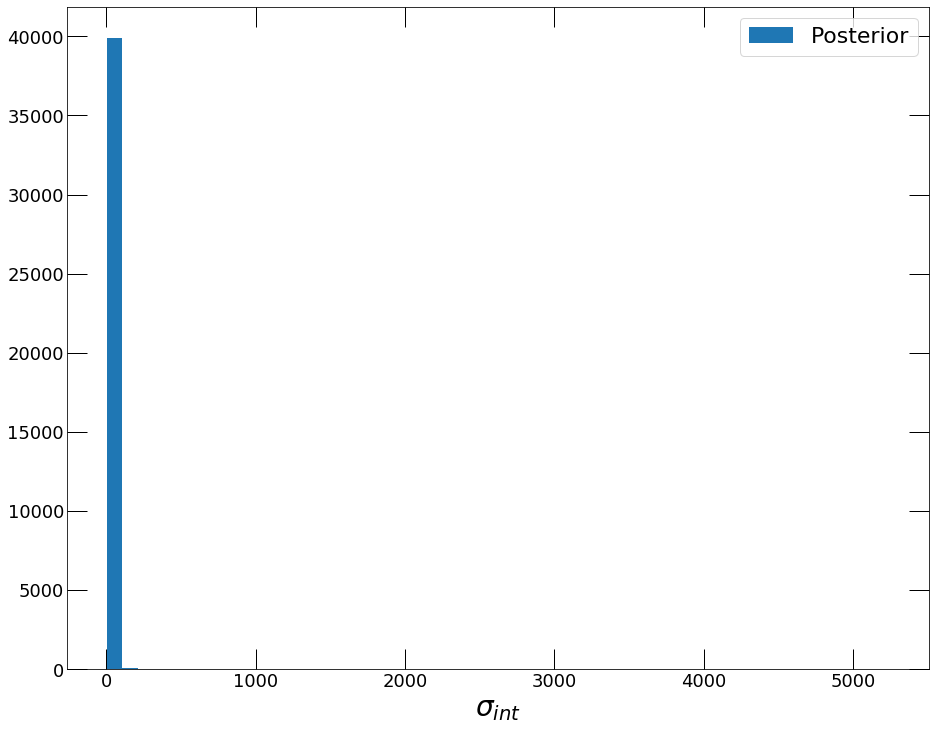

In [175]:
plt.clf()
fig = plt.figure(figsize=(13,10))
ax = fig.add_axes([0.14, 0.14, 0.92, 0.92])
ax.tick_params(length=20, width=1, which='major',direction='in',right='on',top='on')
ax.tick_params(length=10, width=1, which='minor',direction='in',right='on',top='on')
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
    
plt.hist(all_scat, bins=50, label='Posterior')

ylim = ax.get_ylim()
#plt.plot([sigma_int, sigma_int], ylim, ':', color='black', label='True value')
plt.xlabel('$\sigma_{int}$', fontsize=28)

xlim = ax.get_xlim()
plt.axis([xlim[0], xlim[1], ylim[0], ylim[1]])

plt.legend(fontsize=22)
